# Tarea 2:

Prototipa un modelo en Python que permita estimar el precio de una casa dadas algunas características que el usuario deberá proporcionar a través de un front al momento de la inferencia.


El dataset contiene información sobre ventas de productos de distintas tiendas. Lo que se busca predecir son las ventas mensuales por producto-categoría.

Consta de 5 archivos:

    sales_train.csv: Contiene el historial de ventas mensuales.
    
    test.csv: Datos para predecir las ventas futuras.

    items.csv: Información sobre los productos (nombre, categoría, etc.).

    item_categories.csv: Categorías de los productos.

    shops.csv: Información sobre las tiendas.


## Data Information

Carga de Datos, Librerías y Funciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install xgboost
from modules.data_utils import DataProcessor
from modules.eda_utils import *
from modules.get1_cleaning import SalesCleaner
from modules.get2_engineering import FeatureEngineering
from modules.get3_preparing import DataPreparation
from modules.get4_select_model import ModelTraining

pd.options.display.float_format = '{:.2f}'.format

In [67]:
data_path = "../data/raw/"
sales_train = pd.read_csv(data_path + "sales_train.csv")
shops = pd.read_csv(data_path + "shops.csv")
items = pd.read_csv(data_path + "items.csv")
item_categories = pd.read_csv(data_path + "item_categories.csv")
test = pd.read_csv(data_path + "test.csv")
# submission = pd.read_csv(data_path + "sample_submission.csv")

## Data Knowledge

In [68]:
# Cargar archivos principales
df_dict = {
    "sales_train": sales_train,
    "shops": shops,
    "items": items,
    "item_categories": item_categories,
    "test": test
}

# Recorrer cada DataFrame y mostrar información
for name, df in df_dict.items():
    print(f"\n🔹 DataFrame: {name}")
    print("-" * 40)
    print(f"📌 Head (3 primeras filas):")
    print(df.head(3))
    print("\n📌 Info:")
    print(df.info())
    print("=" * 60)



🔹 DataFrame: sales_train
----------------------------------------
📌 Head (3 primeras filas):
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00          1.00
1  03.01.2013               0       25     2552      899.00          1.00
2  05.01.2013               0       25     2552      899.00         -1.00

📌 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

🔹 DataFrame: shops
----------------------------------------
📌 Head (3 primeras filas):
                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Ц

### Resumen de los DataFrames

**sales_train (Historial de ventas)**

- **Tamaño:** 2,935,849 registros y 6 columnas.
- **Variables:**
  - `date`: Fecha de la venta (**formato texto, se necesita transformar**).
  - `date_block_num`: Índice mensual (0 = enero 2013, 33 = octubre 2015).
  - `shop_id`: ID de la tienda.
  - `item_id`: ID del producto.
  - `item_price`: Precio unitario del producto.
  - `item_cnt_day`: Cantidad vendida por día (**puede ser negativa si hubo devoluciones**).

---

**shops (Tiendas)**

- **Tamaño:** 60 registros y 2 columnas.
- **Variables:**
  - `shop_name`: Nombre de la tienda (**en ruso, con caracteres especiales**).
  - `shop_id`: ID único de la tienda.
- **Observaciones:**
  - Algunos nombres de tiendas pueden estar duplicados con ligeras variaciones (por ejemplo, sucursales en diferentes centros comerciales).
  - Puede ser útil extraer información geográfica si los nombres incluyen ciudades.

---

**items (Productos)**
- **Tamaño:** 22,170 registros y 3 columnas.
- **Variables:**
  - `item_name`: Nombre del producto (**contiene caracteres especiales**).
  - `item_id`: ID único del producto.
  - `item_category_id`: Categoría del producto.
- **Observaciones:**
  - Algunos productos pueden repetirse si hay versiones diferentes del mismo (ej., ediciones especiales).
  - Es posible agrupar productos por categoría (`item_category_id`) para generar agregaciones.

---

**item_categories (Categorías de productos)**
- **Tamaño:** 84 registros y 2 columnas.
- **Variables:**
  - `item_category_name`: Nombre de la categoría (**en ruso**).
  - `item_category_id`: ID de la categoría.
- **Observaciones:**
  - Puede ser útil hacer una traducción de las categorías para análisis exploratorio.
  - Algunas categorías pueden agruparse en clases más generales (ej., accesorios de consolas, software, etc.).

---

**test (Datos para predicción)**
- **Tamaño:** 214,200 registros y 3 columnas.
- **Variables:**
  - `ID`: Índice único para la predicción.
  - `shop_id`: ID de la tienda.
  - `item_id`: ID del producto.
- **Observaciones:**
  - No contiene `item_cnt_day`, ya que es lo que se busca predecir.
  - Se debe asignar `date_block_num = 34` (noviembre de 2015) antes de hacer la predicción.


Una vez analizado los registros de los datos, se continuará con la limpieza de cada dataframe para su posterior manejo y unión de datos

Se verifica la cantidad de nulos en cada dataframe

### Completitud

In [69]:
# Recorrer cada DataFrame y mostrar información
for name, df in df_dict.items():
    print(f"\n🔹 DataFrame: {name}")
    print("-" * 40)
    print(DataProcessor.completitud(df))
    print("=" * 60)


🔹 DataFrame: sales_train
----------------------------------------
         variable  num_nulos  completitud
0            date          0       100.00
1  date_block_num          0       100.00
2         shop_id          0       100.00
3         item_id          0       100.00
4      item_price          0       100.00
5    item_cnt_day          0       100.00

🔹 DataFrame: shops
----------------------------------------
    variable  num_nulos  completitud
0  shop_name          0       100.00
1    shop_id          0       100.00

🔹 DataFrame: items
----------------------------------------
           variable  num_nulos  completitud
0         item_name          0       100.00
1           item_id          0       100.00
2  item_category_id          0       100.00

🔹 DataFrame: item_categories
----------------------------------------
             variable  num_nulos  completitud
0  item_category_name          0       100.00
1    item_category_id          0       100.00

🔹 DataFrame: test
--

### Limpieza de Datos

Aparentemente no tenemos registros nulos en ningun dataframe, por lo que se continua con la limpieza de variables en cada dataframe

In [42]:
sales_train = SalesCleaner(sales_train).execute_transformations()

In [43]:
print(sales_train.head(2))
print("=" * 80)
print(sales_train.describe())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00          1.00   
1 2013-01-03               0       25     2552      899.00          1.00   

  month_year  
0    2013-01  
1    2013-01  
                                date  date_block_num    shop_id    item_id  \
count                        2935849      2935849.00 2935849.00 2935849.00   
mean   2014-04-03 05:44:34.970681344           14.57      33.00   10197.23   
min              2013-01-01 00:00:00            0.00       0.00       0.00   
25%              2013-08-01 00:00:00            7.00      22.00    4476.00   
50%              2014-03-04 00:00:00           14.00      31.00    9343.00   
75%              2014-12-05 00:00:00           23.00      47.00   15684.00   
max              2015-10-31 00:00:00           33.00      59.00   22169.00   
std                              NaN            9.42      16.23    6324.30   

       item_price  item

Vamos con el siguiente, es shops

In [44]:
shops = DataProcessor.translate_column(shops, "shop_name")

In [45]:
print(shops.head(2))
print("=" * 80)
print(shops.describe())
# todo se ve bien

                       shop_name  shop_id                         shop_name_es
0  !Якутск Орджоникидзе, 56 фран        0   !Yakutsk Ordzhonikidze, 56 francos
1  !Якутск ТЦ "Центральный" фран        1  !Centro comercial Yakutsk "Central"
       shop_id
count    60.00
mean     29.50
std      17.46
min       0.00
25%      14.75
50%      29.50
75%      44.25
max      59.00


Vamos con items, en este caso no hay mucho que hacer, ya que son 22,169 palabras en ruso, por lo que hacer una traducción de cada producto se volvería algo sumamente costoso computacionalmente, sólo hay que verificar que los items_id tengan sentido tengan sentido

In [46]:
print(items.head(2))
print("=" * 80)
print(items.describe())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   

   item_category_id  
0                40  
1                76  
       item_id  item_category_id
count 22170.00          22170.00
mean  11084.50             46.29
std    6400.07             15.94
min       0.00              0.00
25%    5542.25             37.00
50%   11084.50             40.00
75%   16626.75             58.00
max   22169.00             83.00


In [47]:
item_categories = DataProcessor.translate_column(item_categories, "item_category_name")

In [48]:
print(item_categories.head(2))
print("=" * 80)
print(item_categories.describe())

        item_category_name  item_category_id         item_category_name_es
0  PC - Гарнитуры/Наушники                 0  PC - Auriculares/Auriculares
1         Аксессуары - PS2                 1              Accesorios - PS2
       item_category_id
count             84.00
mean              41.50
std               24.39
min                0.00
25%               20.75
50%               41.50
75%               62.25
max               83.00


In [13]:
print(test.head(2))
print("=" * 60)
print(test.describe())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
             ID   shop_id   item_id
count 214200.00 214200.00 214200.00
mean  107099.50     31.64  11019.40
std    61834.36     17.56   6252.64
min        0.00      2.00     30.00
25%    53549.75     16.00   5381.50
50%   107099.50     34.50  11203.00
75%   160649.25     47.00  16071.50
max   214199.00     59.00  22167.00


### Unión de Data

In [49]:
train = sales_train.merge(shops, on = "shop_id", how = "left")
train = train.merge(items, on = "item_id", how = "left")
train = train.merge(item_categories, on = "item_category_id", how = "left")
# train.to_csv("../data/train.csv", index=False)

## Data Analysis

In [3]:
train = pd.read_csv("../data/train.csv")
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month_year,shop_name,shop_name_es,item_name,item_category_id,item_category_name,item_category_name_es
0,2013-01-02,0,59,22154,999.00,1.00,2013-01,"Ярославль ТЦ ""Альтаир""","Centro comercial ""Altair"" de Yaroslavl",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Cine - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.00,2013-01,"Москва ТРК ""Атриум""",Centro de Rehabilitación y Restauración de Mos...,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Música - Vinilo


### Item Price

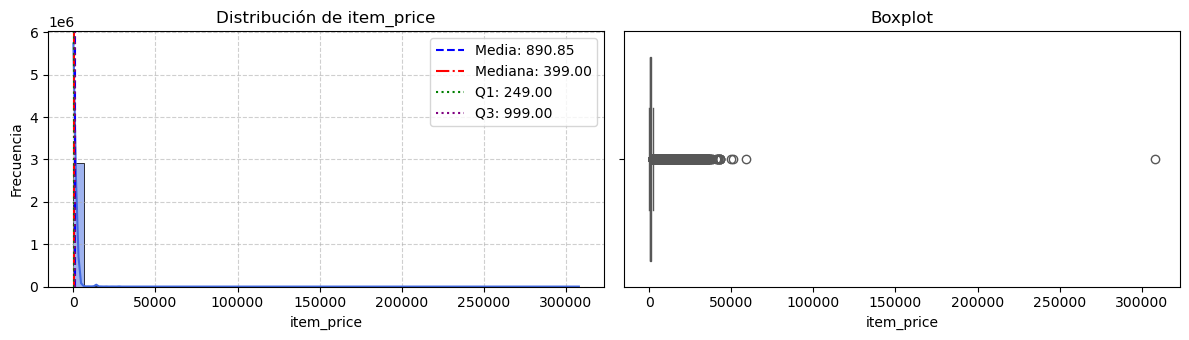

In [71]:
plot_distribution(train, "item_price", title=None, clip_min=None, clip_max=None, figsize=(12, 3.5), color='royalblue')

In [4]:
summary_df_ip, filtered_data_ip = detect_outliers(train, "item_price", iqr_factor=1.5, z_threshold=3, lower_percentile=0.01, upper_percentile=0.99)

In [74]:
summary_df_ip

,Método,Límite Inferior,Límite Superior,Datos Outliers,Datos Sin Outliers,Porcentaje Outliers (%)
0,IQR,-876.00,2124.00,258942,2676907,8.82
1,Z-Score,-4298.55,6080.25,28701,2907148,0.98
2,Percentiles,5.00,5999.00,35033,2900816,1.19


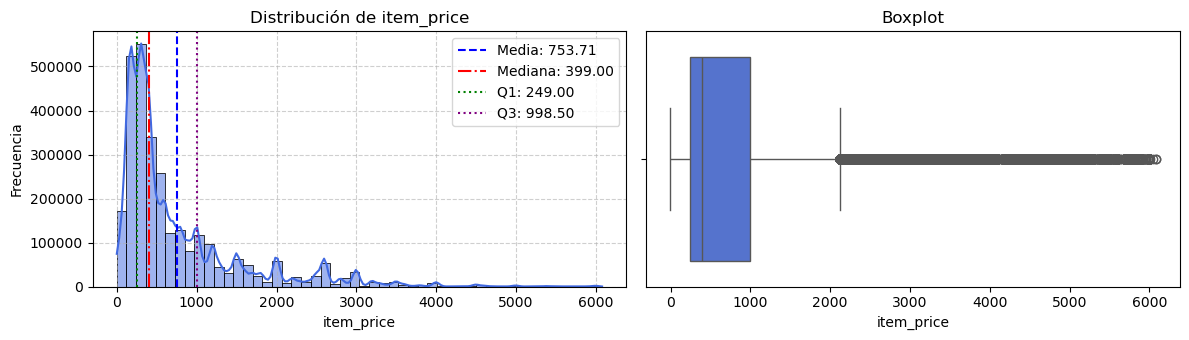

In [75]:
plot_distribution(filtered_data_ip["Z-Score"], "item_price", title=None, clip_min=None, clip_max=None, figsize=(12, 3.5), color='royalblue')

Nos quedaremos con el método de Z-Score, donde se pierden 28 mil registros, pero se mantiene una gran proporción de los datos y la distribución muestra un comportamiento más similar a la realidad de la mayoría de los productos

In [5]:
train = filtered_data_ip["Z-Score"].reset_index(drop=True)

### Shop y Category Name

/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/eda_utils.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_selling_df, x=group_by, y="item_cnt_day", palette="tab10")


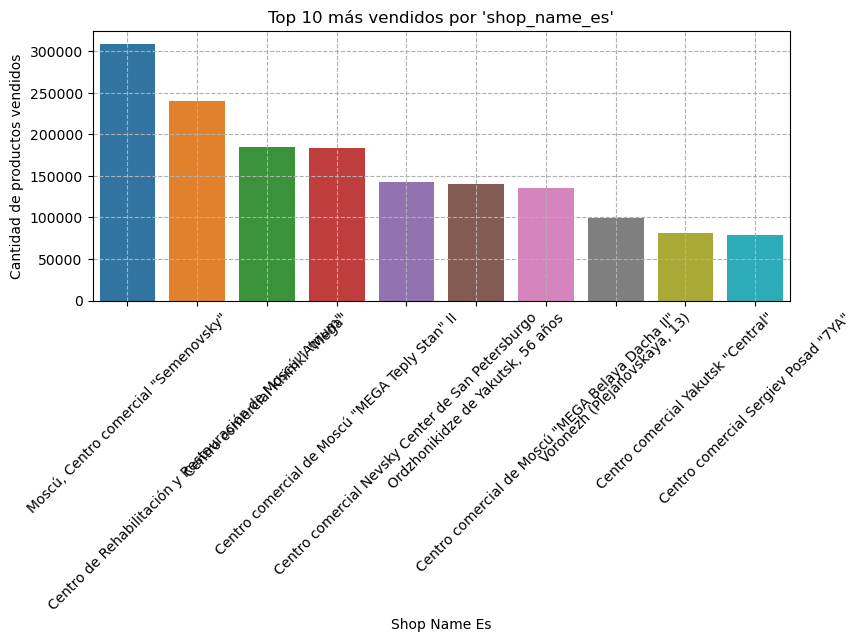

,shop_name_es,item_cnt_day
50,"Moscú, Centro comercial ""Semenovsky""",308747.00
41,Centro de Rehabilitación y Restauración de Mos...,239840.00
19,"Centro comercial Khimki ""Mega""",184499.00
35,"Centro comercial de Moscú ""MEGA Teply Stan"" II",183151.00
23,Centro comercial Nevsky Center de San Petersburgo,143030.00
52,"Ordzhonikidze de Yakutsk, 56 años",139576.00
34,"Centro comercial de Moscú ""MEGA Belaya Dacha II""",135032.00
59,"Voronezh (Plejánovskaya, 13)",99437.00
31,"Centro comercial Yakutsk ""Central""",80804.00
25,"Centro comercial Sergiev Posad ""7YA""",78218.00


In [77]:
top_sellers(train, "shop_name_es",top_n=10)

/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/eda_utils.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_selling_df, x=group_by, y="item_cnt_day", palette="tab10")


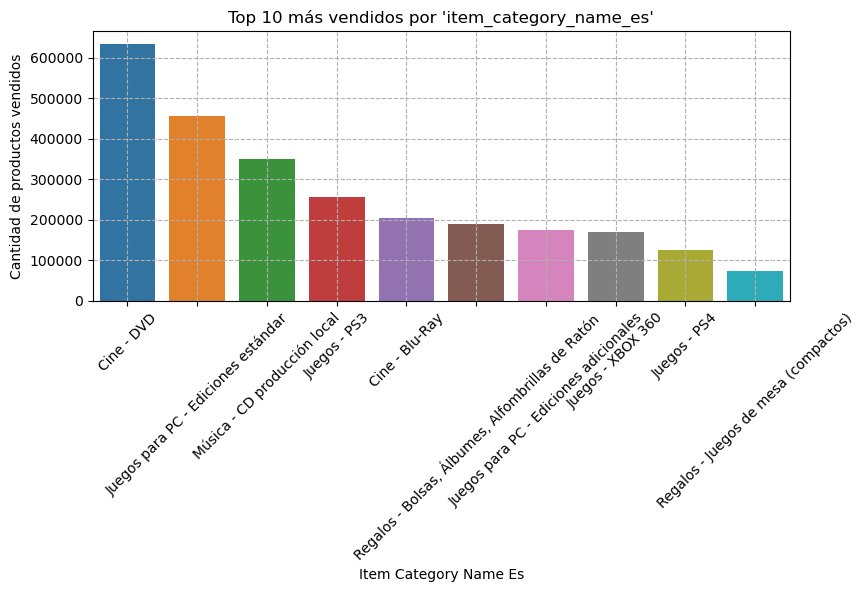

,item_category_name_es,item_cnt_day
12,Cine - DVD,634171.00
36,Juegos para PC - Ediciones estándar,456540.00
52,Música - CD producción local,348591.00
25,Juegos - PS3,254881.00
8,Cine - Blu-Ray,203284.00
66,"Regalos - Bolsas, Álbumes, Alfombrillas de Ratón",187998.00
34,Juegos para PC - Ediciones adicionales,174954.00
29,Juegos - XBOX 360,169901.00
26,Juegos - PS4,125143.00
72,Regalos - Juegos de mesa (compactos),73075.00


In [78]:
top_sellers(train, "item_category_name_es",top_n=10)

## Feature Engineering


**Target 1: Predicción de la cantidad de ventas (`item_cnt_day`)** 📈
- Variables de tendencia de ventas (históricas y recientes).
- Lag Features (ventas pasadas como predictores del futuro).
- Crecimiento o decrecimiento en ventas.
- Impacto de precios en la cantidad vendida.
- Factores temporales y estacionales (ventas en distintos meses/días).

**Target 2: Predicción de si un producto se venderá (`item_cnt_day > 0`)** ✅❌
- Frecuencia de venta del producto en la tienda.
- Ventas en los últimos N días (¿se ha vendido recientemente?).
- Precio relativo a productos similares.
- Popularidad de la categoría o tienda.
- Impacto de promociones o descuentos.

---

**Transformaciones en el Feature Engineering**

*Variables Temporales** ⏳
- `month`: Mes de la venta.
- `day_of_week`: Día de la semana.
- `season`: Estación del año.

**Variables de Ventas** 📊
- `total_sales`: Ventas totales acumuladas por `shop_id + item_id`.
- `avg_sales_per_shop_item`: Ventas promedio por tienda y producto.
- `sales_lag_1m`: Ventas del mes anterior (Lag Feature, imputado con 0).

**Variables de Precio** 💰
- `avg_price_per_shop_item`: Precio promedio de cada producto en cada tienda.
- `price_deviation`: Desviación del precio actual con respecto al promedio histórico.

**Variables para Clasificación** ✅❌
- `sales_frequency`: Frecuencia con la que un producto ha sido vendido en una tienda.
- `recent_sales`: Suma de ventas en los últimos 7 días (útima semana).

In [6]:
train["date"] = pd.to_datetime(train["date"], format="%Y-%m-%d")

In [7]:
t = train.copy()
train_model = FeatureEngineering(t, target="item_cnt_month").apply_feature_engineering()

In [8]:
train_model.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_category_id,total_sales,avg_sales_per_shop_item,sales_lag_1m,sales_lag_3m,sales_lag_6m,avg_price_per_shop_item,price_deviation,avg_sales_per_category,category_trend_last_3m,category_sales_rank
0,1,0,32,6.00,221.00,4,16.00,8.00,0.00,0.00,0.00,221.00,0.00,4.84,0.00,4619.00
1,1,0,33,3.00,347.00,3,6.00,3.00,0.00,0.00,0.00,347.00,0.00,3.36,0.00,61537.00
2,1,0,35,1.00,247.00,1,15.00,7.50,0.00,0.00,0.00,247.00,0.00,1.02,0.00,542578.00


## Preparing Data

**1. Manejo de Valores Faltantes**
- Rellenar valores faltantes en variables de ventas y precios.
- Imputación en features de Lag con 0 para evitar pérdida de información.

**2. Normalización y Escalado**
- Aplicar normalización si se usarán modelos sensibles a la escala de datos.
- StandardScaler o MinMaxScaler según el modelo seleccionado.

**3. División en Conjunto de Entrenamiento y Validación**
- Crear una estrategia para evaluar el modelo antes de predecir en el test set.
- Dividir los datos en entrenamiento y validación con base en el tiempo.

**4. Manejo de Variables Categóricas**
- Codificar `shop_id` y otras variables categóricas para el modelo.
- Utilizar One-Hot Encoding o Label Encoding según el tipo de modelo.

**5. Selección de Variables Útiles**
- Decidir qué variables serán utilizadas en el modelo.
- Eliminar variables redundantes o con alta correlación.

---

**📊 Pasos en la Preparación de Datos**

1. **Carga de datos**: Asegurar que los datos estén correctamente formateados.
2. **Manejo de valores nulos**: Rellenar valores faltantes.
3. **Codificación de variables categóricas**: Convertir IDs de tiendas y productos en variables numéricas.
4. **Escalado de variables numéricas**: Aplicar escalado para modelos sensibles a la magnitud de los datos.
5. **División en entrenamiento y validación**: Separar los datos para evaluar el modelo antes de predecir en el test set.

/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lag_features] = df[lag_features].fillna(0)
/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.median(), inplace=True)
/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:43: SettingWithCopyWarning: 
A v

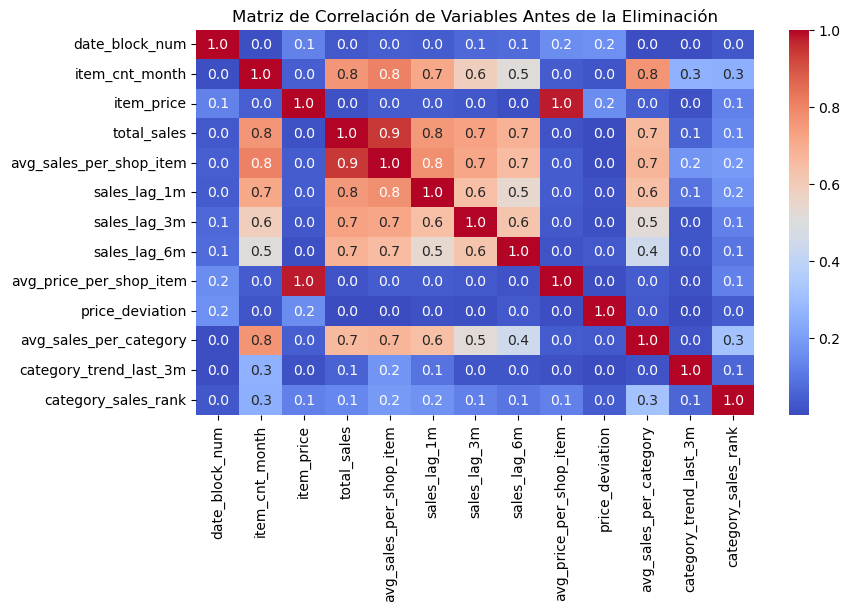

/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=to_drop, inplace=True)


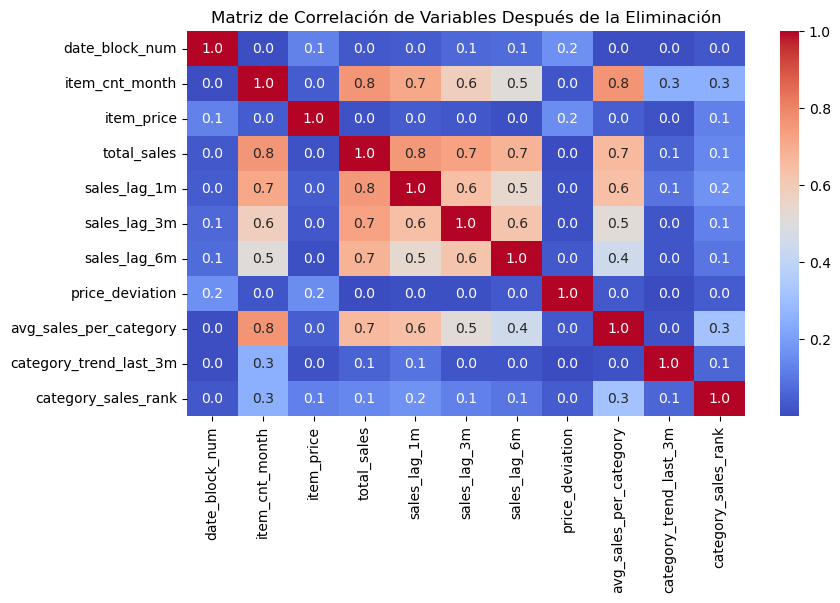

/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.transformed_columns] = self.scaler.fit_transform(df[self.transformed_columns])
/Users/danielmpr/Documents/ITAM/ArquitecturaGranEscala/ArquitecturaGranEscala/tareas/t2/src/modules/get3_preparing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lag_features] = df[lag_features].fillna(0)
/Users/danielmpr/Documents/ITAM/Arquitectur

In [9]:
data_prep = DataPreparation(train_model, target="item_cnt_month")
X_train, X_val, y_train, y_val = data_prep.prepare_data()


In [10]:
X_train

,date_block_num,item_price,total_sales,sales_lag_1m,sales_lag_3m,sales_lag_6m,price_deviation,avg_sales_per_category,category_trend_last_3m,category_sales_rank
0,1,-0.58,-0.06,-0.24,-0.18,-0.13,-0.04,0.40,-0.02,-1.70
1,1,-0.41,-0.12,-0.24,-0.18,-0.13,-0.04,0.17,-0.02,-1.44
2,1,-0.55,-0.07,-0.24,-0.18,-0.13,-0.04,-0.20,-0.02,0.71
3,1,-0.58,-0.15,-0.24,-0.18,-0.13,-0.04,-0.20,-0.02,0.71
4,1,-0.71,-0.13,-0.24,-0.18,-0.13,-0.01,-0.03,-0.02,-1.07
...,...,...,...,...,...,...,...,...,...,...
1371527,27,-0.67,0.08,-0.11,-0.05,0.18,1.36,-0.20,-0.02,0.71
1371528,27,-0.64,0.36,0.14,0.22,0.48,2.53,-0.03,0.39,-1.66
1371529,27,-0.75,-0.15,-0.24,-0.18,-0.13,-0.04,-0.20,-0.02,0.71
1371530,27,-0.34,-0.06,0.88,-0.18,-0.13,0.36,0.40,-0.02,-1.57


## 📌 Model Predict

**1. Definir el Objetivo del Modelo**
- **Series Temporales**: Predecir ventas futuras para `shop_id + item_id`.
- **Regresión**: Estimar la cantidad de ventas `item_cnt_day`.
- **Clasificación**: Predecir si un producto se venderá (`item_cnt_day > 0`).

**2. Selección del Modelo**
- **Series Temporales**: `ARIMA`, `Prophet`, `LSTM`.
- **Regresión**: `XGBoost`, `LightGBM`, `Random Forest`.
- **Clasificación**: `Logistic Regression`, `XGBoost`, `Random Forest`.

**3. Entrenamiento y Evaluación del Modelo**
- **Dividir los datos** en entrenamiento y validación.
- **Evaluar el rendimiento** con métricas adecuadas:
  - `RMSE` para regresión.
  - `Accuracy` / `AUC` para clasificación.

**4. Optimización de Hiperparámetros**
- **Utilizar** `GridSearchCV` o `RandomSearchCV` para encontrar la mejor configuración del modelo.

**5. Predicciones en el Conjunto de Test**
- **Aplicar el modelo** en los datos de test.
- **Analizar resultados** y generar predicciones finales.

---

📊 **Pasos en el Modelado Predictivo**

1. **Carga de datos**: Asegurar que los datos estén correctamente preparados.
2. **Definir el tipo de modelo**: `Series Temporales`, `Regresión` o `Clasificación`.
3. **Entrenar el modelo**: Ajustar el modelo con los datos de entrenamiento.
4. **Evaluar el rendimiento**: Usar métricas adecuadas para medir precisión y error.
5. **Optimización**: Ajustar hiperparámetros para mejorar resultados.
6. **Generar predicciones**: Aplicar el modelo en el dataset de test y analizar resultados.


In [11]:
# Uso de la clase con datos preparados
model_trainer = ModelTraining(X_train, X_val, y_train, y_val, "random_forest")

In [12]:
best_model, train_rmse, val_rmse = model_trainer.train_and_evaluate_model()

Entrenando modelo: random_forest...
random_forest - RMSE en entrenamiento: 0.5944
random_forest - RMSE en validación: 5.0986
Mejor modelo: random_forest con RMSE en validación: 5.0986


In [114]:
best_model

RandomForestRegressor(random_state=42)

In [23]:
# import joblib
# filename = '../models/rfm_model.sav'
# joblib.dump(best_model, filename)
#loaded_model = joblib.load(filename)

## Verificar resultados

In [110]:
y_predict_train = pd.DataFrame(best_model.predict(X_train[[column for column in X_train if column not in ["date_block_num"]]])).rename(columns={0:"y_predict"})
y_predict_val = pd.DataFrame(best_model.predict(X_val[[column for column in X_val if column not in ["date_block_num","avg_price_per_shop_item", "avg_sales_per_shop_item"]]])).rename(columns={0:"y_predict"})

In [111]:
Train = pd.concat([pd.concat([X_train,pd.DataFrame(y_train)],axis=1).reset_index(), y_predict_train.reset_index(drop=True)], axis = 1)
Val = pd.concat([pd.concat([X_val,pd.DataFrame(y_val)],axis=1).reset_index(), y_predict_val.reset_index(drop=True)], axis = 1)

In [114]:
Train = Train[["date_block_num", "item_cnt_month","y_predict"]]
Val = Val[["date_block_num", "item_cnt_month","y_predict"]]
Train["flag"] = "Train"
Val["flag"] = "Test"

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_2544/2571547778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train["flag"] = "Train"


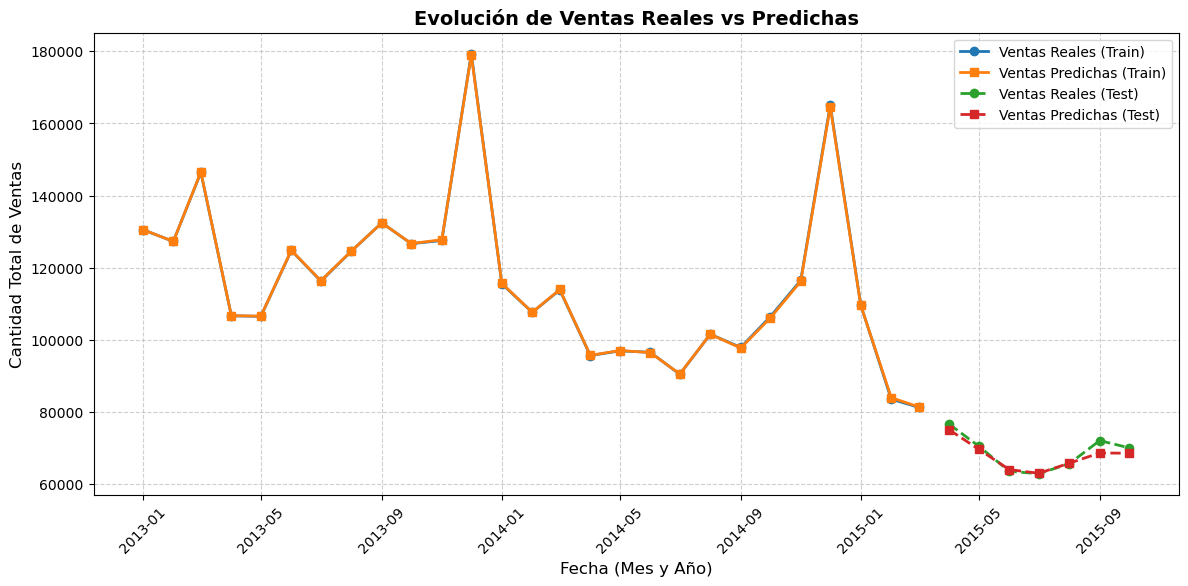

In [134]:
results_df = pd.concat([Train,Val], axis=0)
df_month = train[["date_block_num","month_year"]].drop_duplicates()
df_month["date_block_num"] = df_month["date_block_num"] + 1
results_df = pd.merge(results_df,df_month, on="date_block_num",how="left")
results_df["month_year"] = pd.to_datetime(results_df["month_year"])

# Agregar valores por mes y conjunto (Train/Test)
agg_df = results_df.groupby(['month_year', 'flag']).agg({
    'item_cnt_month': 'sum',
    'y_predict': 'sum'
}).reset_index()


plt.figure(figsize=(18, 6))


train_df = agg_df[agg_df['flag'] == 'Train']
plt.plot(train_df['month_year'], train_df['item_cnt_month'], label='Ventas Reales (Train)', marker='o', linestyle='-', linewidth=2)
plt.plot(train_df['month_year'], train_df['y_predict'], label='Ventas Predichas (Train)', marker='s', linestyle='-', linewidth=2)


test_df = agg_df[agg_df['flag'] == 'Test']
plt.plot(test_df['month_year'], test_df['item_cnt_month'], label='Ventas Reales (Test)', marker='o', linestyle='--', linewidth=2)
plt.plot(test_df['month_year'], test_df['y_predict'], label='Ventas Predichas (Test)', marker='s', linestyle='--', linewidth=2)


plt.xlabel('Fecha (Mes y Año)', fontsize=12)
plt.ylabel('Cantidad Total de Ventas', fontsize=12)
plt.title('Evolución de Ventas Reales vs Predichas', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.xticks(rotation=45)  # Mejorar la legibilidad del eje X
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar la gráfica
plt.show()


In [22]:
# X_train.to_csv("../data/train_test/X_train.csv",index=False)
# X_columns = [column for column in X_train.columns if column not in ["avg_price_per_shop_item", "avg_sales_per_shop_item"]]
# X_val[X_columns].to_csv("../data/train_test/X_val.csv",index=False)
# y_train.to_csv("../data/train_test/y_train.csv",index=False)
# y_val.to_csv("../data/train_test/y_val.csv",index=False)

In [98]:
# param_grids = {
#     "xgboost": {"n_estimators": [100, 200], "max_depth": [3, 6], "learning_rate": [0.01, 0.1]},
#     "random_forest": {"n_estimators": [100, 200], "max_depth": [10, 20]}
# }
# model_trainer.optimize_hyperparameters(param_grids)

In [117]:
# predictions = model_trainer.predict(X_val[[column for column in X_val if column not in ["avg_price_per_shop_item", "avg_sales_per_shop_item"]]])